# Debugging DL-Front Results

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib import cm
import matplotlib as mpl
import cartopy.feature as cfeature

### Function to calculate monthly rate climatologies

In [3]:
# function for calculating seasonal climatological rates over CONUS (spatial field, spatial mean, spatial stdev)
def mrates_clim_CONUS(path, file, grid):

    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # process seasonal rate climatology and standard deviation
    mrates_clim = rates_fronts.monthly_rate_climatology
    mrates_clim_stdev = rates_fronts.monthly_rate_climatology_stdev
    
    # check gridtype
    # approx. lat/lon here to get a CONUS rectangular region - may not exactly match Jim's analysis
    if grid=="CESM":
        mrates_clim_CONUS = mrates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
        mrates_clim_stdev_CONUS = mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
    elif grid=="MERRA":
        mrates_clim_CONUS = mrates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
        mrates_clim_stdev_CONUS = mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
    
    # average over CONUS
    weights = np.cos(np.deg2rad(mrates_clim_CONUS.lat))
    weights.name = "weights"
    mrates_clim_CONUS_weighted = mrates_clim_CONUS.weighted(weights)
    mrates_clim_CONUS_weighted_mean = mrates_clim_CONUS_weighted.mean(("lon","lat"))
    mrates_clim_stdev_CONUS_weighted = mrates_clim_stdev_CONUS.weighted(weights)
    mrates_clim_stdev_CONUS_weighted_mean = mrates_clim_stdev_CONUS_weighted.mean(("lon","lat"))
    
    return(mrates_clim_CONUS, mrates_clim_stdev_CONUS, mrates_clim_CONUS_weighted_mean, mrates_clim_stdev_CONUS_weighted_mean)

### Function to calculate seasonal rate climatologies

In [40]:
# function for calculating seasonal climatological rates over CONUS (spatial field, spatial mean, spatial stdev)
def srates_clim_CONUS(path, file, grid):

    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # process seasonal rate climatology and standard deviation
    srates_clim = rates_fronts.seasonal_rate_climatology
    srates_clim_stdev = rates_fronts.seasonal_rate_climatology_stdev
    
    # check gridtype
    # approx. lat/lon here to get a CONUS rectangular region - may not exactly match Jim's analysis
    if grid=="CESM":
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
    elif grid=="MERRA":
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
    
    # average over CONUS
    weights = np.cos(np.deg2rad(srates_clim_CONUS.lat))
    weights.name = "weights"
    srates_clim_CONUS_weighted = srates_clim_CONUS.weighted(weights)
    srates_clim_CONUS_weighted_mean = srates_clim_CONUS_weighted.mean(("lon","lat"))
    srates_clim_stdev_CONUS_weighted = srates_clim_stdev_CONUS.weighted(weights)
    srates_clim_stdev_CONUS_weighted_mean = srates_clim_stdev_CONUS_weighted.mean(("lon","lat"))
    
    return(srates_clim_CONUS, srates_clim_stdev_CONUS, srates_clim_CONUS_weighted_mean, srates_clim_stdev_CONUS_weighted_mean)

### Read in Coded Surface Bulletin files

In [78]:
csb_filepath = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
csb_masked_rates_file = "codsus_masked_frontRates_2003-2015.nc" # masked to compare with Jim's analysis
csb_masked_mrates_clim_CONUS, csb_masked_mrates_clim_stdev_CONUS, csb_masked_mrates_clim_CONUS_mean, csb_masked_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(csb_filepath, csb_masked_rates_file, "MERRA")
csb_masked_srates_clim_CONUS, csb_masked_srates_clim_stdev_CONUS, csb_masked_srates_clim_CONUS_mean, csb_masked_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(csb_filepath, csb_masked_rates_file, "MERRA")

In [68]:
csb_rates_file = "codsus_frontRates_2003-2015.nc" # unmasked to compare with CESM output
csb_mrates_clim_CONUS, csb_mrates_clim_stdev_CONUS, csb_mrates_clim_CONUS_mean, csb_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(csb_filepath, csb_rates_file, "MERRA")
csb_srates_clim_CONUS, csb_srates_clim_stdev_CONUS, csb_srates_clim_CONUS_mean, csb_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(csb_filepath, csb_rates_file, "MERRA")

In [9]:
csb_rates_fronts = xr.open_dataset(csb_filepath+csb_rates_file)

## Debugging the standard deviation discrepancy

<xarray.DataArray ()>
array(0.08330001)
Coordinates:
    clim_months  datetime64[ns] 2009-01-15
    front_type   object 'all'

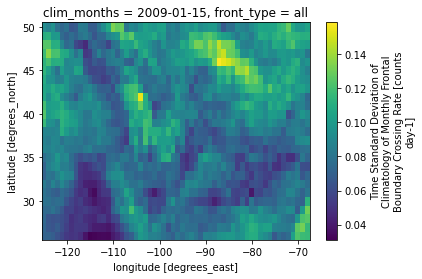

In [7]:
# look spatially at stdev counts per day - order of magnitude looks right for the spatial mean
csb_mrates_clim_stdev_CONUS[0,4,:,:].plot();
csb_mrates_clim_stdev_CONUS_mean[0,4]

In [10]:
# calculate the stdev manually based on monthly rate
csb_mrates = csb_rates_fronts.monthly_rate
csb_mrates_std = csb_mrates.groupby("months.month").std("months")
csb_mrates_std_CONUS = csb_mrates_std.sel(lat=slice(26,50), lon=slice(-125, -68))
weights = np.cos(np.deg2rad(csb_mrates_std_CONUS.lat))
weights.name = "weights"
csb_mrates_std_CONUS_weighted = csb_mrates_std_CONUS.weighted(weights)
csb_mrates_std_CONUS_weighted_mean = csb_mrates_std_CONUS_weighted.mean(("lon","lat"))
csb_mrates_std_CONUS_weighted_mean[:,4]

<xarray.DataArray (month: 12)>
array([0.08330001, 0.08703383, 0.08898776, 0.07833854, 0.08185299,
       0.0815198 , 0.07592456, 0.07868185, 0.07127922, 0.07455   ,
       0.06990523, 0.08475019])
Coordinates:
    front_type  object 'all'
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

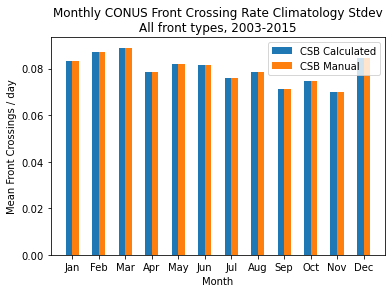

In [11]:
# comparing stdev (calculated/manual) - they are the same!
fig, ax = plt.subplots()

w = 0.25
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x - (w/2)
ax.bar(position, csb_mrates_clim_stdev_CONUS_mean[:,4], width=w, label="CSB Calculated", color='C0', capsize=3, zorder=3)
position = x + (w/2)
ax.bar(position, csb_mrates_std_CONUS_weighted_mean[:,4], width=w, label="CSB Manual", color='C1', capsize=3, zorder=3)

ax.set_title('Monthly CONUS Front Crossing Rate Climatology Stdev\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / day')
ax.set_xlabel('Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

In [12]:
# read in the csb files directly
csb_narr_filepath = "/glade/work/kdagon/ML-extremes/data/CODSUS/NARR/"
csb_narr_rates_file = "codsus_masked_narr-96km_rates_2003-2015.nc" # downloaded directly from Jim's paper (not calculated)
csb_narr_rates_fronts = xr.open_dataset(csb_narr_filepath+csb_narr_rates_file)

In [13]:
csb_narr_rates_fronts.monthly_rate_climatology_stdev

<xarray.DataArray 'monthly_rate_climatology_stdev' (months12: 12, front: 5, y: 92, x: 116)>
[640320 values with dtype=float32]
Coordinates:
  * y           (y) float64 2.724e+04 1.247e+05 2.222e+05 ... 8.802e+06 8.9e+06
  * x           (x) float64 2.61e+04 1.236e+05 2.211e+05 ... 1.114e+07 1.124e+07
    lat         (y, x) float64 ...
    lon         (y, x) float64 ...
    front_type  (front) object ...
Dimensions without coordinates: months12, front
Attributes:
    grid_mapping:  crs
    long_name:     Time Standard Deviation of Climatology of Monthly Frontal ...
    valid_min:     0
    cell_methods:  time: standard_deviation within years time: standard_devia...
    units:         counts day-1
    valid_max:     31

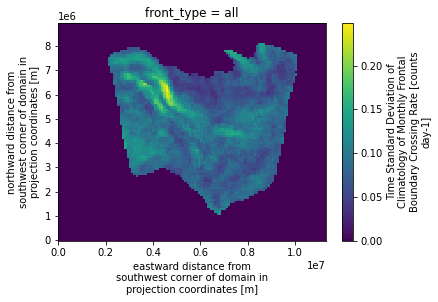

In [14]:
# note different coordinates here...
csb_narr_rates_fronts.monthly_rate_climatology_stdev[0,4,:,:].plot();
# units are per day...the numbers in Jim's spreadsheet look very small compare to this plot (stdev=0.02 events/day)

In [15]:
# rough spatial mean including all the zeros - is that what's driving the low values?
csb_narr_rates_fronts.monthly_rate_climatology_stdev.mean(('x','y'))[:,4]

<xarray.DataArray 'monthly_rate_climatology_stdev' (months12: 12)>
array([0.03276861, 0.03517324, 0.03330119, 0.03229036, 0.03223196,
       0.0311469 , 0.03128187, 0.03072169, 0.02950566, 0.03100442,
       0.03120891, 0.03329951], dtype=float32)
Coordinates:
    front_type  object 'all'
Dimensions without coordinates: months12

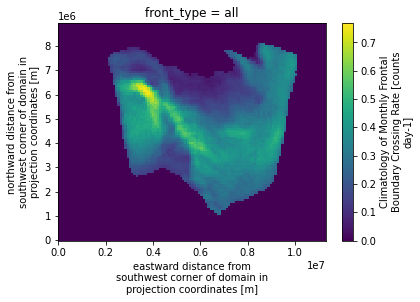

In [16]:
# look at the rates - looks similar (per day)
csb_narr_rates_fronts.monthly_rate_climatology[0,4,:,:].plot();

In [17]:
# read in the area average csb file
csb_narr_rates_avg_file = "codsus_masked_narr-all_rates_2003-2015.nc" # downloaded directly from Jim's paper (not calculated)
csb_narr_rates_avg_fronts = xr.open_dataset(csb_narr_filepath+csb_narr_rates_avg_file)

In [18]:
# rates for all fronts are comparable
csb_narr_rates_avg_fronts.monthly_rate_climatology[:,4,0,0]

<xarray.DataArray 'monthly_rate_climatology' (months12: 12)>
array([0.304147, 0.31043 , 0.306243, 0.290344, 0.266967, 0.253183, 0.2347  ,
       0.247535, 0.253749, 0.283272, 0.287006, 0.298897], dtype=float32)
Coordinates:
    y           float64 3.44e+06
    x           float64 6.364e+06
    lat         float64 ...
    lon         float64 ...
    front_type  object ...
Dimensions without coordinates: months12
Attributes:
    grid_mapping:  crs
    long_name:     Climatology of Monthly Frontal Boundary Crossing Rate
    valid_min:     0
    cell_methods:  time: mean within years time: mean over years
    units:         counts day-1
    valid_max:     31

In [19]:
# stdev are comparable to my results
csb_narr_rates_avg_fronts.monthly_rate_climatology_stdev[:,4,0,0]

<xarray.DataArray 'monthly_rate_climatology_stdev' (months12: 12)>
array([0.077077, 0.083165, 0.082536, 0.072476, 0.075978, 0.07862 , 0.073925,
       0.075527, 0.068885, 0.070908, 0.06531 , 0.078382], dtype=float32)
Coordinates:
    y           float64 3.44e+06
    x           float64 6.364e+06
    lat         float64 ...
    lon         float64 ...
    front_type  object ...
Dimensions without coordinates: months12
Attributes:
    grid_mapping:  crs
    long_name:     Time Standard Deviation of Climatology of Monthly Frontal ...
    valid_min:     0
    cell_methods:  time: standard_deviation within years time: standard_devia...
    units:         counts day-1
    valid_max:     31

## Debugging the gridding artifacts

### Read in CESM files

In [21]:
cesm_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"

In [30]:
cesm_rates_file = "cesm_fronts_2003-2015_frontRates_viaPolylines.nc" # rates calculated via polyline analysis (to better compare to Jim's analysis)
cesm_rates_fronts = xr.open_dataset(cesm_filepath+cesm_rates_file)

In [41]:
cesm_srates_clim_CONUS, cesm_srates_clim_stdev_CONUS, cesm_srates_clim_CONUS_mean, cesm_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_rates_file, "MERRA")

In [22]:
# investigate the MaskedNetCDF files versus the OneHot files
cesm_MaskedNetCDF_file = "cesm_fronts_2000-2015_MaskedNetCDF_v2.nc"
cesm_OneHot_file = "cesm_frontsOneHot_2000-2015.nc"

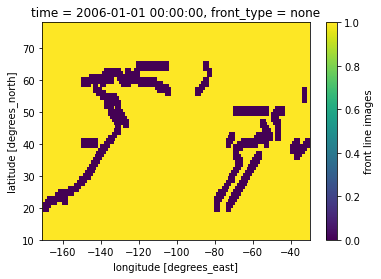

In [23]:
cesm_MN_fronts = xr.open_dataset(cesm_filepath+cesm_MaskedNetCDF_file)
cesm_MN_fronts.fronts.sel(time='2006-01-01',front=4)[0,:,:].plot();

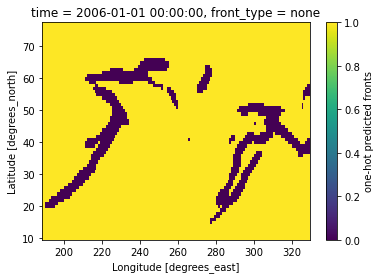

In [24]:
cesm_OH_fronts = xr.open_dataset(cesm_filepath+cesm_OneHot_file)
cesm_OH_fronts.fronts.sel(time='2006-01-01',front=4)[0,:,:].plot();

How is OH file different?
For some reason when run through the rates calculator, the spatial mapping is very spotty for MN

### Look at a CSB MaskedNetCDF file (downloaded not processed)

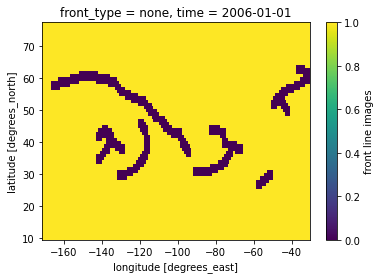

In [25]:
csb_MaskedNetCDF_file = "codsus_merra2-1deg_3wide_2006.nc"
csb_MN_fronts = xr.open_dataset(csb_filepath+csb_MaskedNetCDF_file)
csb_MN_fronts.fronts.sel(time='2006-01-01',front=4)[0,:,:].plot();

### Read in MERRA files

In [52]:
merra_filepath = "/glade/work/kdagon/FrontDetector/MERRAOutputs/"
merra_rates_file = "merra_fronts_2003-2015_frontRates_viaPolylines.nc"
merra_srates_clim_CONUS, merra_srates_clim_stdev_CONUS, merra_srates_clim_CONUS_mean, merra_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(merra_filepath, merra_rates_file, "MERRA")

In [70]:
merra_filepath_v2 = '/glade/work/kdagon/ML-extremes/data/merra2_fronts/' # downloaded MERRA data
merra_rates_file_v2 = 'merra2_3wide_3hr_frontRates_2003-2015.nc'
merra_rates_fronts_v2 = xr.open_dataset(merra_filepath_v2+merra_rates_file_v2)
merra_srates_clim_CONUS_v2, merra_srates_clim_stdev_CONUS_v2, merra_srates_clim_CONUS_mean_v2, merra_srates_clim_stdev_CONUS_mean_v2 = srates_clim_CONUS(merra_filepath_v2, merra_rates_file_v2, "MERRA")

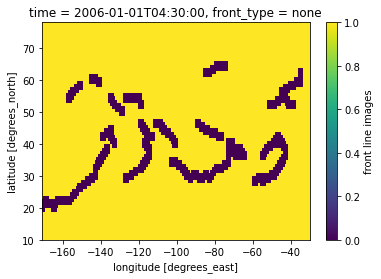

In [53]:
# look at a MERRA MaskedNetCDF file (processed)
merra_MN_fronts = xr.open_dataset(merra_filepath+'merra_fronts_2000-2015_MaskedNetCDF.nc')
merra_MN_fronts.fronts.sel(time='2006-01-01',front=4)[1,:,:].plot();
# does look choppier here?

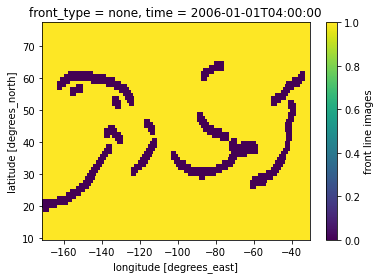

In [69]:
# compare the above to Jim's MERRA file - closest time index (not exactly aligning in time)
merra_MN_fronts_v2 = xr.open_dataset(merra_filepath_v2+'merra2_merra2-1deg_3wide_2006.nc')
merra_MN_fronts_v2.fronts.isel(time=4,front=4)[:,:].plot();

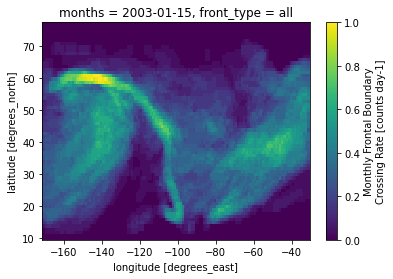

In [71]:
# look at the resulting rates file (calculated from downloaded merra data) - plotting artifacts aren't visible
merra_rates_fronts_v2.monthly_rate[0,4,:,:].plot();

### Look at MERRA sample data and calculated rates

In [84]:
sample_file_path = "/glade/work/kdagon/FrontDetector/postprocessing/"
sample_rates_file = "sample_fronts_2009_FrontCrossings_viaPolylines.nc"
sample_rates_fronts = xr.open_dataset(sample_file_path+sample_rates_file)

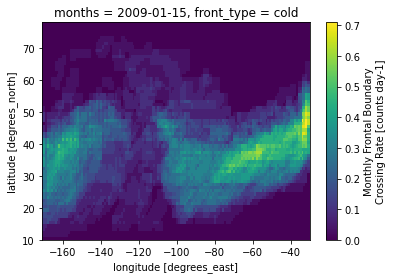

In [85]:
sample_rates_fronts.monthly_rate[0,0,:,:].plot()

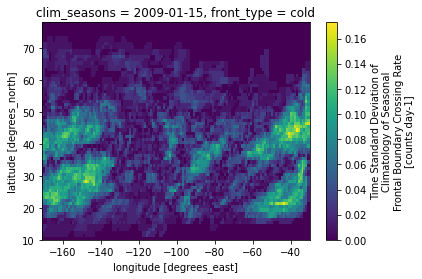

In [86]:
sample_rates_fronts.seasonal_rate_climatology_stdev[0,0,:,:].plot()

You can even see it in the sample single year file using the sample input data Jim provided - must be something in the polylines workflow

In [89]:
# rates from sampled-generated one-hot file
sample_OH_rates_file = "sample_fronts_2009_FrontCrossings.nc"
sample_OH_rates_fronts = xr.open_dataset(sample_file_path+sample_OH_rates_file)

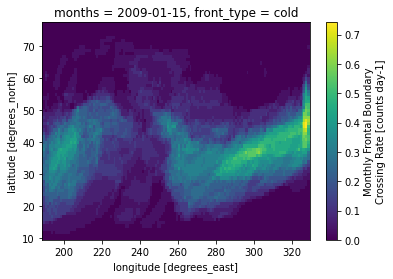

In [90]:
sample_OH_rates_fronts.monthly_rate[0,0,:,:].plot()

In [91]:
# masked netcdf file
sample_MN_fronts_file = "sample_fronts_2009_MaskedNetCDF.nc"
sample_MN_fronts = xr.open_dataset(sample_file_path+sample_MN_fronts_file)

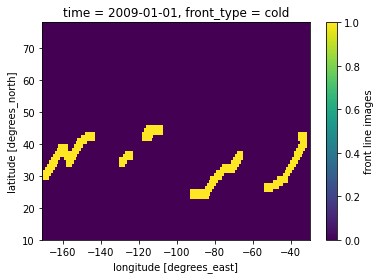

In [94]:
sample_MN_fronts.fronts.sel(time='2009-01-01',front=0)[0,:,:].plot()

### Look at the cesm rates file again, start from the least amount of time averaging (monthly rate)

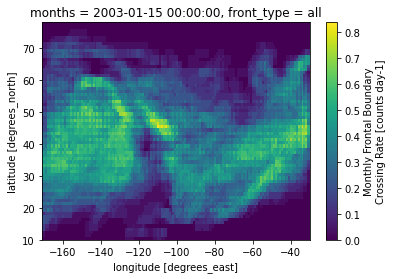

In [31]:
cesm_rates_fronts.monthly_rate[0,4,:,:].plot();

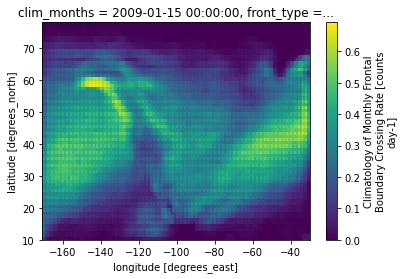

In [32]:
cesm_rates_fronts.monthly_rate_climatology[0,4,:,:].plot();

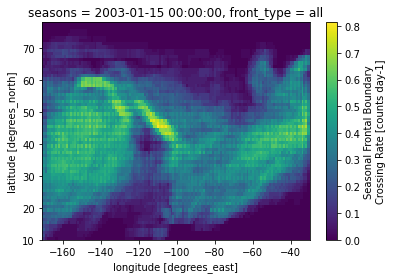

In [33]:
cesm_rates_fronts.seasonal_rate[0,4,:,:].plot();

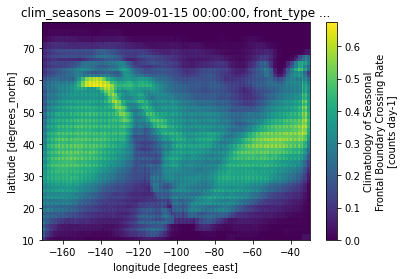

In [34]:
cesm_rates_fronts.seasonal_rate_climatology[0,4,:,:].plot();

In [35]:
# grab the OH rates file
cesm_rates_OH_file = "cesm_frontRates_2003-2015.nc"
cesm_rates_OH_fronts = xr.open_dataset(cesm_filepath+cesm_rates_OH_file)

In [61]:
cesm_OH_srates_clim_CONUS, cesm_OH_srates_clim_stdev_CONUS, cesm_OH_srates_clim_CONUS_mean, cesm_OH_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_rates_OH_file, "CESM")

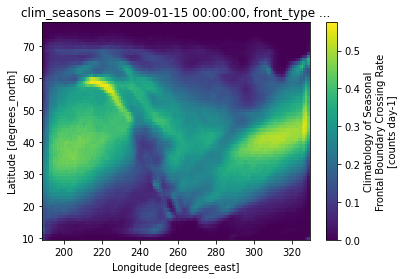

In [62]:
cesm_rates_OH_fronts.seasonal_rate_climatology[0,4,:,:].plot();

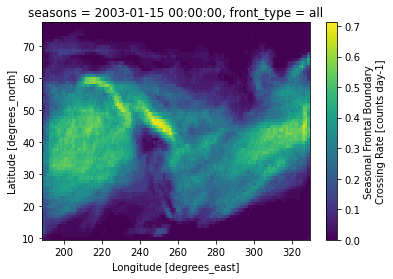

In [63]:
cesm_rates_OH_fronts.seasonal_rate[0,4,:,:].plot();

why are the rates generated via one-hots so much smoother? 

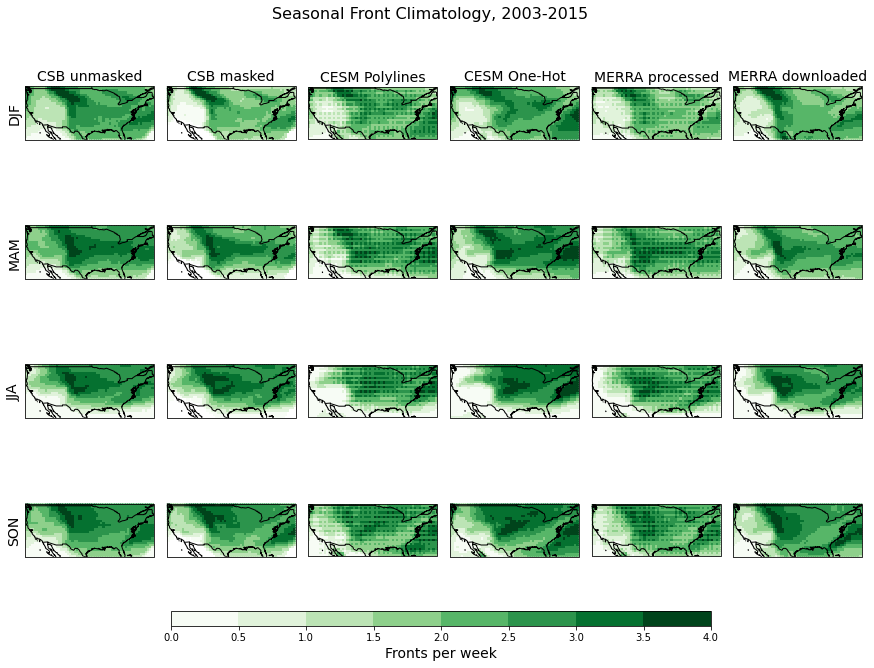

In [80]:
# try plotting with an explicit colorbar as in Jim's Fig 6

# by season type and trim domain to CONUS
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 6, figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('CSB unmasked', fontsize=14) 
    field, lon = add_cyclic_point((csb_srates_clim_CONUS*7)[i,4,:,:], coord=csb_srates_clim_CONUS.lon)
    lat = csb_srates_clim_CONUS.lat
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) 
    #cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation, but pcolormesh adds a white border
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
    # see also: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html#differences-pcolor-pcolormesh
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    #axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Climatology, 2003-2015', fontsize=16, y=0.94)
 
for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('CSB masked', fontsize=14) 
    field, lon = add_cyclic_point((csb_masked_srates_clim_CONUS*7)[i,4,:,:], coord=csb_masked_srates_clim_CONUS.lon)
    lat = csb_masked_srates_clim_CONUS.lat
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) 
    #cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation, but pcolormesh adds a white border
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)

for i in range(nsea):
    if i == 0:
        axs[i,2].set_title('CESM Polylines', fontsize=14)
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_srates_clim_CONUS.lon)
    lat = cesm_srates_clim_CONUS.lat
    #cf = axs[i,2].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    #cf = axs[i,2].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)
    
# also compare CESM rates via OneHot file
for i in range(nsea):
    if i == 0:
        axs[i,3].set_title('CESM One-Hot', fontsize=14)
    field, lon = add_cyclic_point((cesm_OH_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_OH_srates_clim_CONUS.lon)
    lat = cesm_OH_srates_clim_CONUS.lat
    #cf = axs[i,3].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    #cf = axs[i,3].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    cf = axs[i,3].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    axs[i,3].coastlines()
    axs[i,3].add_feature(cfeature.BORDERS)
    
for i in range(nsea):
    if i == 0:
        axs[i,4].set_title('MERRA processed', fontsize=14)
    field, lon = add_cyclic_point((merra_srates_clim_CONUS*7)[i,4,:,:], coord=merra_srates_clim_CONUS.lon)
    lat = merra_srates_clim_CONUS.lat
    #cf = axs[i,4].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    #cf = axs[i,4].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    cf = axs[i,4].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    axs[i,4].coastlines()
    axs[i,4].add_feature(cfeature.BORDERS)
    
for i in range(nsea):
    if i == 0:
        axs[i,5].set_title('MERRA downloaded', fontsize=14)
    field, lon = add_cyclic_point((merra_srates_clim_CONUS_v2*7)[i,4,:,:], coord=merra_srates_clim_CONUS_v2.lon)
    lat = merra_srates_clim_CONUS_v2.lat
    #cf = axs[i,5].contourf(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    #cf = axs[i,5].pcolormesh(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    cf = axs[i,5].pcolor(lon, lat, field, cmap=cmap, transform=ccrs.PlateCarree())
    axs[i,5].coastlines()
    axs[i,5].add_feature(cfeature.BORDERS)
    
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
#cmap = mpl.cm.Greens
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

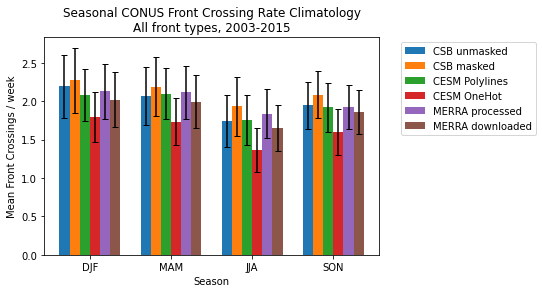

In [83]:
# compare seasonal climatological spatial averages across all datasets
fig, ax = plt.subplots()

labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

# set number of bars per x label to find optimal positions
nbars=6

# width
w = 0.75/nbars

position = x + (w*(1-nbars)/2) + 0*w
ax.bar(position, (csb_srates_clim_CONUS_mean*7)[:,4], yerr=(csb_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB unmasked", color='C0', capsize=3)
position = x + (w*(1-nbars)/2) + 1*w
ax.bar(position, (csb_masked_srates_clim_CONUS_mean*7)[:,4], yerr=(csb_masked_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB masked", color='C1', capsize=3)
position = x + (w*(1-nbars)/2) + 2*w
ax.bar(position, (cesm_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM Polylines", color='C2', capsize=3)
position = x + (w*(1-nbars)/2) + 3*w
ax.bar(position, (cesm_OH_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_OH_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM OneHot", color='C3', capsize=3)
position = x + (w*(1-nbars)/2) + 4*w
ax.bar(position, (merra_srates_clim_CONUS_mean*7)[:,4], yerr=(merra_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="MERRA processed", color='C4', capsize=3)
position = x + (w*(1-nbars)/2) + 5*w
ax.bar(position, (merra_srates_clim_CONUS_mean_v2*7)[:,4], yerr=(merra_srates_clim_stdev_CONUS_mean_v2*7)[:,4], width=w, label="MERRA downloaded", color='C5', capsize=3)

ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));